In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import os
from keras import layers

from data_processing import *
from training_utils import *



2024-04-15 11:32:22.662151: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 11:32:22.686092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
MODEL_WEIGHTS_PATH="local_runs/tiny_XS_model/04-13-18:59_model_emd256_DH4_EH4_EPS30_LR0.0001.h5"
MODEL_CONFIG_PATH="local_runs/tiny_XS_model/trial_config.json"
TOKENIZER_PATH="local_runs/tiny_XS_model/tokenizer.keras"

In [16]:
with open(MODEL_CONFIG_PATH, "r") as f:
    CONFIG = json.load(f)
    

In [17]:
CONFIG

{'TIMESTAMP': '04-13-18:59',
 'DATA_PATH': 'data/flickr30k_images/',
 'IMAGES_PATH': 'data/flickr30k_images/flickr30k_images/',
 'IMAGE_SIZE': [224, 224],
 'VAL_FRACTION': 0.05,
 'SEQ_LENGTH': 36,
 'VOCAB_SIZE': 10000,
 'BATCH_SIZE': 128,
 'STRIP_CHARS': '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~',
 'EPOCHS': 30,
 'EMBED_DIM': 256,
 'FF_DIM': 256,
 'ENC_HEADS': 4,
 'DEC_HEADS': 4,
 'ARTIFACT_DIR': './local_runs/tiny_XS_model',
 'CNN_MODEL': 'efficientnetb1',
 'LR': 0.0001}

In [18]:
model = load_trained_model_weights(MODEL_WEIGHTS_PATH, CONFIG)

In [19]:
model.summary()

Model: "image_captioning_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 49, 1280)          6575239   
                                                                 
 transformer_encoder_block_  multiple                  1382912   
 1 (TransformerEncoderBlock                                      
 )                                                               
                                                                 
 transformer_decoder_block_  multiple                  7376144   
 1 (TransformerDecoderBlock                                      
 )                                                               
                                                                 
Total params: 15334299 (58.50 MB)
Trainable params: 8759056 (33.41 MB)
Non-trainable params: 6575243 (25.08 MB)
______________________________________________________________

In [20]:
tokenizer = load_tokenizer(TOKENIZER_PATH)

In [21]:
caption_model = model

In [22]:
val_captionings_df = pd.read_csv("splits/val_captions.csv")

vocab = tokenizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = CONFIG["SEQ_LENGTH"] - 1
valid_images = val_captionings_df["image_name"].to_list()

example_images = []
pred_captions = []

import matplotlib.pyplot as plt
def generate_caption(title=False):
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)
    example_images.append(sample_img)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img, CONFIG["IMAGE_SIZE"])
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(7, 7))
    plt.imshow(img / 255.0)
    

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    
    img = caption_model.cnn_model(img)

    
    
    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = tokenizer([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "end":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace("end", "").strip()
    print("Predicted Caption: ", decoded_caption)

    pred_captions.append(decoded_caption)
    if title:
        plt.title(decoded_caption)
    plt.show()

Predicted Caption:  a man in a blue shirt sitting on a couch


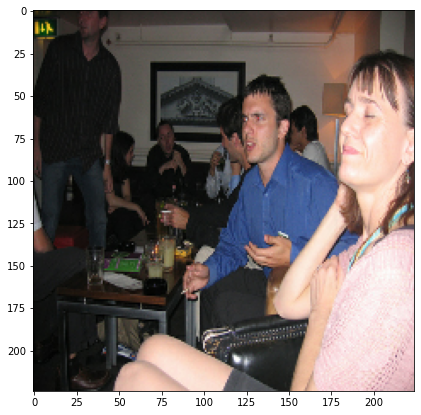

Predicted Caption:  a woman in a white shirt and black sunglasses is standing in the street


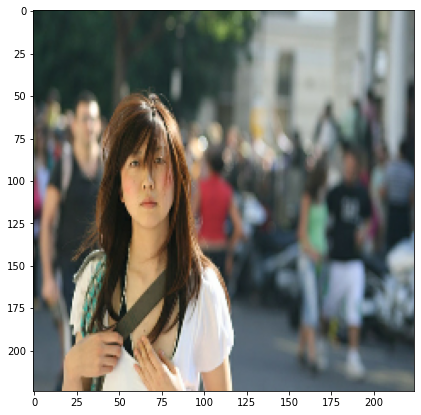

Predicted Caption:  a man is standing on the beach


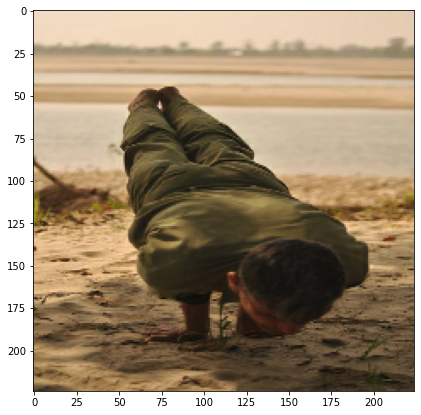

Predicted Caption:  a man in a red jersey is trying to catch a ball


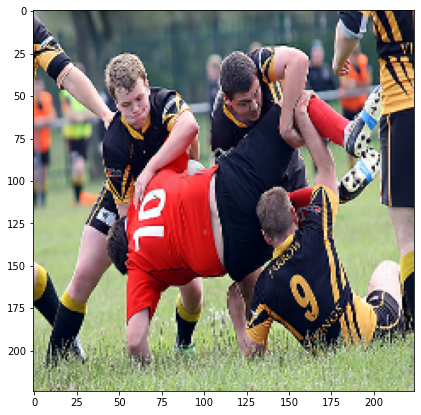

Predicted Caption:  a woman in a costume is holding a stuffed animal


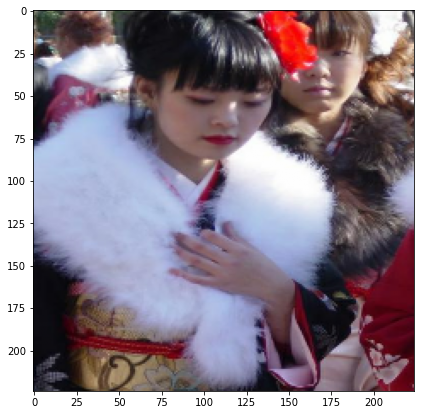

Predicted Caption:  three men are walking down the street


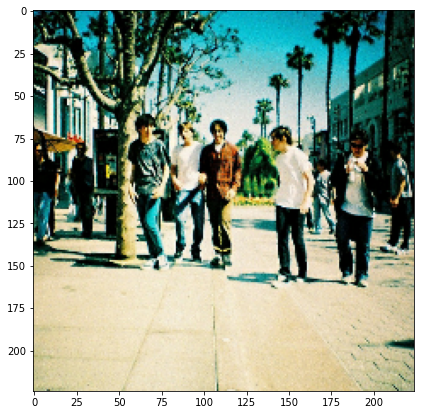

Predicted Caption:  a dog is walking through the snow


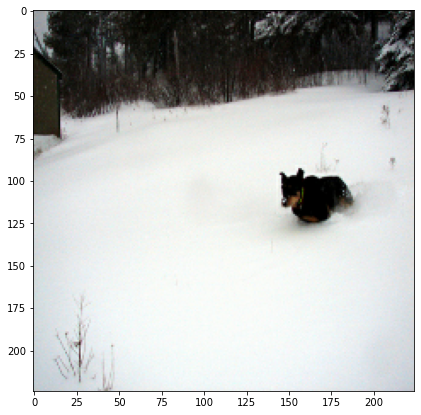

Predicted Caption:  a man in a blue shirt is doing a trick on a bike


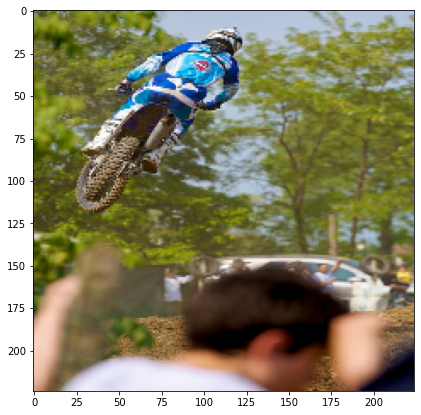

Predicted Caption:  a man in a black jacket riding a bike


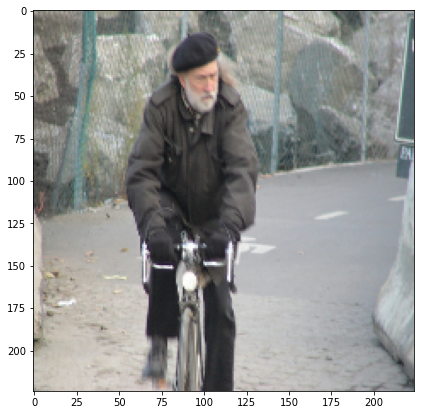

Predicted Caption:  a man in a white shirt and black shorts is playing tennis


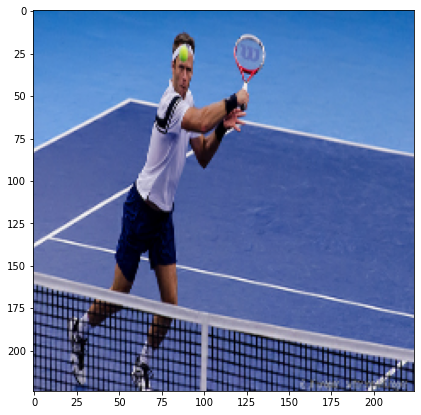

Predicted Caption:  a woman in a red shirt is using a machine


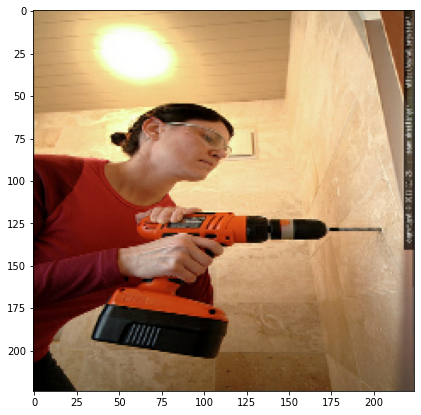

Predicted Caption:  two women are walking down a sidewalk


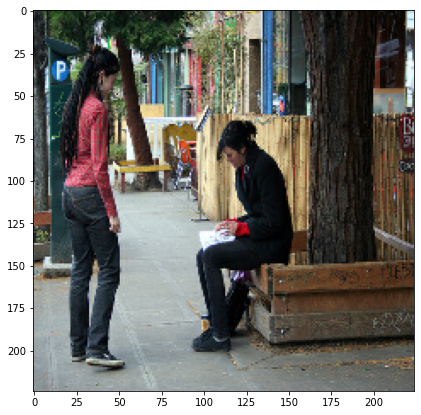

Predicted Caption:  a woman in a brown jacket is standing in front of a large grill


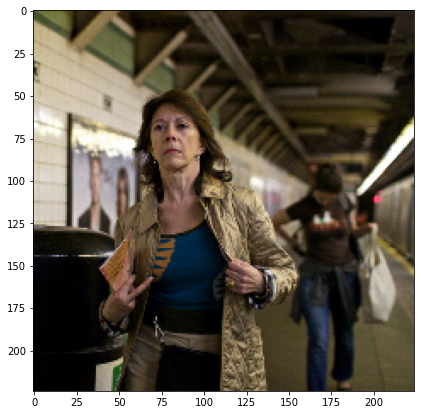

Predicted Caption:  three people are having a good time at a party


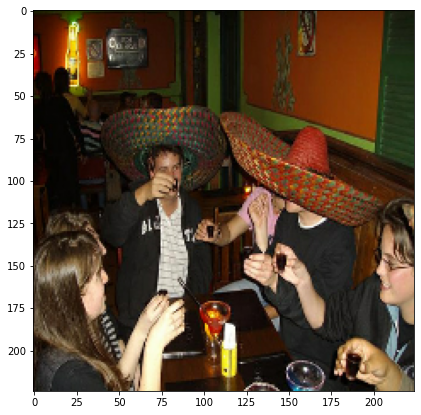

Predicted Caption:  a man is sitting on the sidewalk in front of a wall


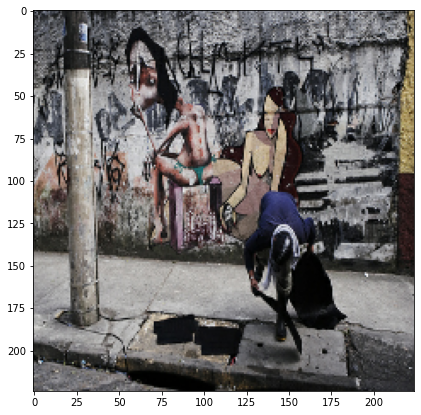

Predicted Caption:  a man is standing in a [UNK] with a gun


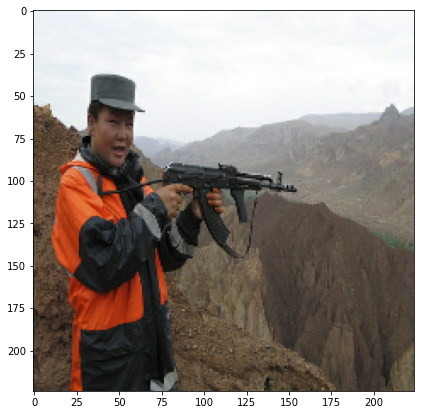

Predicted Caption:  a young girl in a yellow shirt is holding a snail


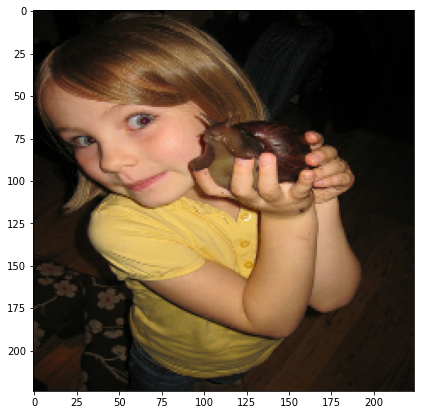

Predicted Caption:  a man in a green tractor is driving down a street


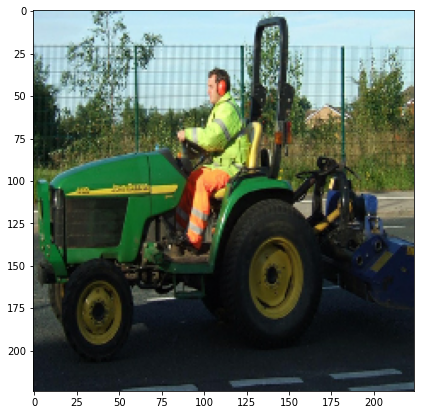

Predicted Caption:  a group of young boys are sitting in a classroom


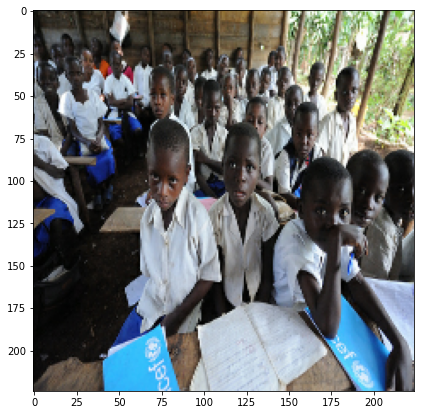

Predicted Caption:  a group of men are playing in a boat


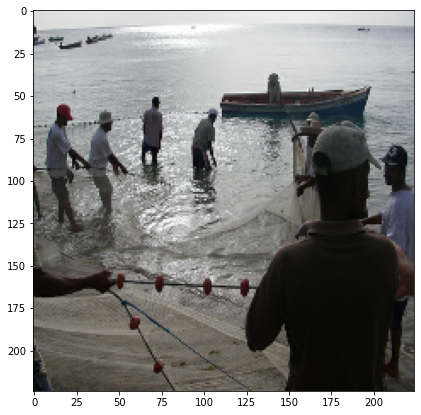

Predicted Caption:  a man and a woman are standing in front of a store


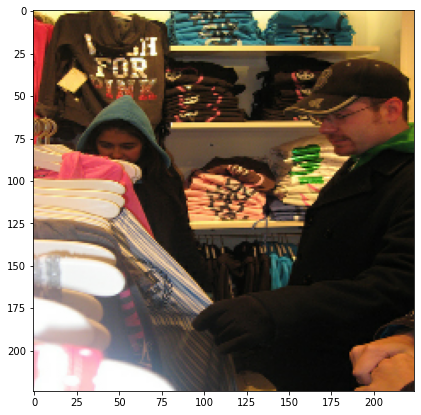

Predicted Caption:  two people are riding a bike in a city


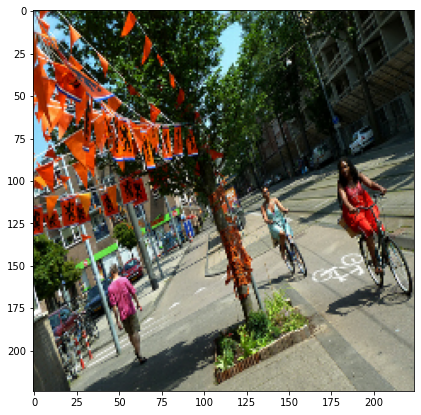

Predicted Caption:  a snowboarder is doing a trick on a snowboard


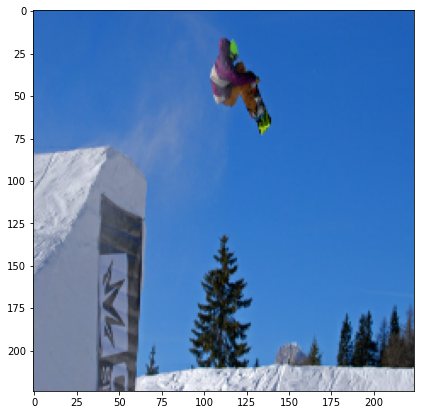

Predicted Caption:  a man sitting in a chair in front of a red wall


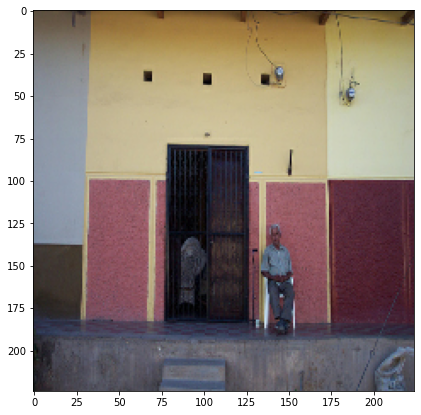

Predicted Caption:  two young girls are standing in a parking lot


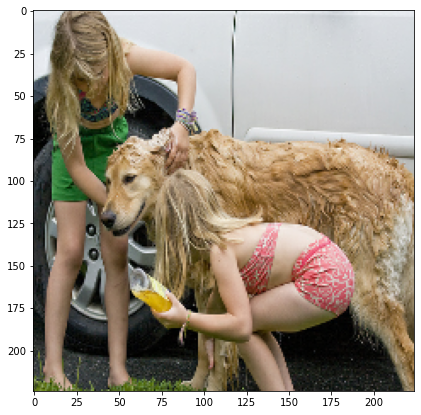

In [24]:
N_TO_GENERATE = 25

for _ in range(N_TO_GENERATE):
    generate_caption()